# TCC - APLICAÇÃO DE MACHINE LEARNING EM ANÁLISE DE COMPARECIMENTO EM CONSULTAS MÉDICAS DO SUS


Este notebook foi desenvolvido para o ambiente GOOGLE COLAB 

THIAGO AUGUSTO COSTA DUARTE

# Inicialização 

A célula a seguir inicializa a plataforma, carregando as bibliotecas que serão relevantes para o trabalho em seguida.

## Bibliotecas
```numpy``` -- usada para processamento numérico.

```pandas``` -- usada para manipulação de bases de dados.

```pyplot``` -- usada para visualização de dados.

```seaborn``` -- usada para visualização de dados.

In [1]:
import pandas as pd
import pydotplus 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)


*   Import do arquivo CRV 
 

*  Essa base de dados pode ser obtida no Kaggle, no endereço: https://www.kaggle.com/joniarroba/noshowappointments


In [2]:
from google.colab import files

uploaded = files.upload()

Saving KaggleV2-May-2016.csv to KaggleV2-May-2016.csv


In [4]:
sus = pd.read_csv(next(iter(uploaded.keys())))

print("\nDimensões de SUS:\n{0}\n".format(sus.shape))
print("\nCampos de SUS:\n{0}\n".format(list(sus.keys())))
print("\nTipos dos dados:\n{0}\n".format(sus.dtypes))


Dimensões de SUS:
(110527, 14)


Campos de SUS:
['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']


Tipos dos dados:
PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object



# 3 - Tratamento de Dados

## 3.1 - Verificação de dados ausentes e duplicados

Valida se existe algum dado ausente

In [67]:
import pandas as pd
sus = pd.read_csv(next(iter(uploaded.keys())))
sus.isnull().values.any()

False

Valida se existe registros duplicados

In [68]:
import pandas as pd
sus = pd.read_csv(next(iter(uploaded.keys())))
sus.duplicated().values.any()

False

## 3.2 - Renomear as colunas

De for a facilitar a manipulação dos dados, foi proposta uma nova renomeação das colunas da base.

In [5]:
sus.rename(columns = {'PatientId': 'PacienteID',
                      'AppointmentID': 'AgendamentoID',
                      'Gender': 'Genero',
                      'ScheduledDay': 'DataMarcacaoConsulta',
                      'AppointmentDay': 'DataConsulta',
                      'Age': 'Idade',
                      'Neighbourhood': 'Bairro',
                      'Scholarship': 'Escolaridade',
                      'Hipertension': 'Hipertensao',
                      'Alcoholism': 'Alcoolismo',
                      'Handcap': 'Deficiencia',
                      'SMS_received': 'SMS_Alerta',
                      }, inplace = True)

print("\nCampos de SUS:\n{0}\n".format(list(sus.keys())))


Campos de SUS:
['PacienteID', 'AgendamentoID', 'Genero', 'DataMarcacaoConsulta', 'DataConsulta', 'Idade', 'Bairro', 'Escolaridade', 'Hipertensao', 'Diabetes', 'Alcoolismo', 'Deficiencia', 'SMS_Alerta', 'No-show']



## 3.3 - Conversão de variaveis 

Conversão do campo 'PacienteID' para o tipo int

In [6]:
sus['PacienteID'] = sus['PacienteID'].astype(np.int64)

Conversão dos campos 'DataMarcacaoConsulta'e 'DataConsulta', para o tipo DATE

In [7]:
sus['PacienteID'] = sus['PacienteID'].astype(np.int64)
sus.DataMarcacaoConsulta = sus.DataMarcacaoConsulta.apply(np.datetime64)
sus.DataConsulta = sus.DataConsulta.apply(np.datetime64)

In [8]:
print("\nTipos dos dados:\n{0}\n".format(sus.dtypes))


Tipos dos dados:
PacienteID                       int64
AgendamentoID                    int64
Genero                          object
DataMarcacaoConsulta    datetime64[ns]
DataConsulta            datetime64[ns]
Idade                            int64
Bairro                          object
Escolaridade                     int64
Hipertensao                      int64
Diabetes                         int64
Alcoolismo                       int64
Deficiencia                      int64
SMS_Alerta                       int64
No-show                         object
dtype: object



## 3.4 - Novas Colunas

1.   Criação da coluna de ```TempoEspera```, é a data do agendamento  - a data da consulta
2.   Padronização da coluna ```Genero``` Afim de padronizar os regitros de 2 valores em boolean.
Para isso , a coluna ```Genero``` vai ser renomeada para ```Genero_Masculino```
3.  Padronização da coluna ```no-show```. Afim de deixar toda a base boolean.
Para isso , a coluna ```no-show``` vai ser renomeada para ```Nao_comparecimento``` 
4. Converte bairro para numeros e criando coluna de ```BirroInt```


In [9]:
def NumeroDias(number):
  number = abs(number)
  return int(np.ceil(number))
  
DiasParaConsulta = sus.DataConsulta - sus.DataMarcacaoConsulta
DiasParaConsulta = DiasParaConsulta.apply(lambda x: x.total_seconds() / (3600 * 24))
sus['TempoEspera'] = DiasParaConsulta.apply(NumeroDias)

In [10]:
def converte_Genero_Masculino (Genero):
  if Genero == 'M':
    return 1
  else:
    return 0
    
sus['Genero_Masculino'] = sus['Genero'].apply(converte_Genero_Masculino)

In [11]:
def converte_no_show (no_show):
  if no_show == 'Yes':
    return 1
  else:
    return 0
  
sus['Nao_comparecimento'] = sus['No-show'].apply(converte_no_show)

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
sus['BirroInt'] = le.fit_transform(sus['Bairro'])

In [77]:
sus.head()  

,PacienteID,AgendamentoID,Genero,DataMarcacaoConsulta,DataConsulta,Idade,Bairro,Escolaridade,Hipertensao,Diabetes,Alcoolismo,Deficiencia,SMS_Alerta,No-show,TempoEspera,Genero_Masculino,Nao_comparecimento,BirroInt
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0,0,39
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1,1,0,39
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0,0,45
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0,0,54
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1,0,0,39


## 3.5 - Estatistica Descritiva dos Dados

In [18]:
# Exibe apenas os campos numméricos:

print(sus.describe())

categ = sus.dtypes[sus.dtypes == "object"].index

print("\n", sus[categ].describe(), sep='\n')

       PacienteID  AgendamentoID      Idade  Escolaridade  Hipertensao  \
count    1.10e+05       1.10e+05  110480.00      110480.0     110480.0   
mean     1.47e+14       5.68e+06      37.06           0.1          0.2   
std      2.56e+14       7.13e+04      23.08           0.3          0.4   
min      3.92e+04       5.03e+06       0.00           0.0          0.0   
25%      4.17e+12       5.64e+06      18.00           0.0          0.0   
50%      3.17e+13       5.68e+06      37.00           0.0          0.0   
75%      9.44e+13       5.73e+06      55.00           0.0          0.0   
max      1.00e+15       5.79e+06      95.00           1.0          1.0   

        Diabetes  Alcoolismo  Deficiencia  SMS_Alerta  TempoEspera  \
count  110480.00   110480.00    110480.00   110480.00    110480.00   
mean        0.07        0.03         0.02        0.32        10.53   
std         0.26        0.17         0.16        0.47        15.03   
min         0.00        0.00         0.00        0.00

Com isso foi possivel validar:
1- Não existe registros vazios 
2- Necessidade de criar um rage para excluir idades erradas na base ex:-1

## 3.6 - Criação do range de idade 

Excluindo os registros com menos de 0 e com mais que 95, uma vez que existem poucos registros com mais que 95 anos.
Assim, foram removidos 47 registros.

In [13]:
sus = sus[(sus.Idade >= 0) & (sus.Idade <= 95)]
print("\nDimensões de SUS:\n{0}\n".format(sus.shape))


Dimensões de SUS:
(110480, 18)



# 4 - Explorando os dados

In [51]:
###### Verifica a quantidade  de registros de não cmomparecimento ######
sus['Nao_comparecimento'].value_counts()



0    88168
1    22312
Name: Nao_comparecimento, dtype: int64

(-1.1008128980357565,
 1.1000387512624161,
 -1.1012158425825715,
 1.1004711456915117)

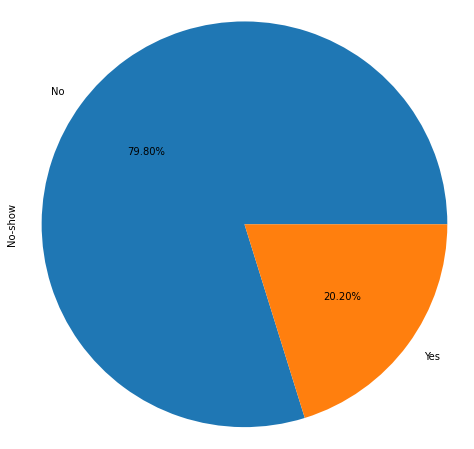

In [53]:
sus['No-show'].value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(8,8))
plt.axis('equal')  # Para deixar o gráfico redondo

## Dritribuição de Genero na Base 

(-1.110896943071702,
 1.1005189020510335,
 -1.112304657804976,
 1.1068434003339573)

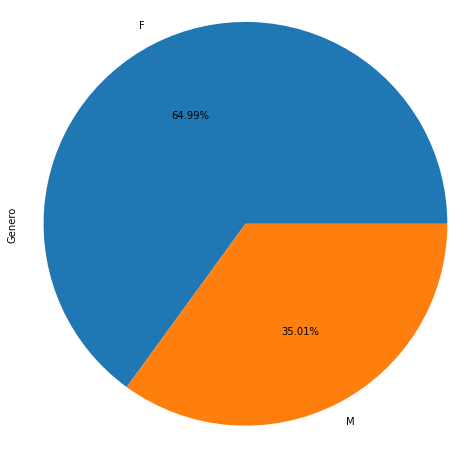

In [54]:
sus['Genero'].value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(8,8))
plt.axis('equal')  # Para deixar o gráfico redondo

## Primeira data e ultima data do registro de uma consulta e uma consulta realizada

In [55]:
print("Data de registro da consulta")
print(sus['DataMarcacaoConsulta'].min())
print(sus['DataMarcacaoConsulta'].max())

print("Data da consulta")
print(sus['DataConsulta'].min())
print(sus['DataConsulta'].max())

Data de registro da consulta
2015-11-10 07:13:56
2016-06-08 20:07:23
Data da consulta
2016-04-29 00:00:00
2016-06-08 00:00:00


## Nova seção

# 5- Aplicação dos algoritmos de MACHINE LEARNING

In [14]:
### Exibe Resultados ####

def obtemMetricasResumido(y_test, y_pred, nome_modelo):
    # Obtendo metricas
    print("\nAcurácia de previsão - "+ nome_modelo +":", accuracy_score(y_test, y_pred))
    print("---------------------------------------------------------------------------- ")
    print(classification_report(y_test, y_pred, target_names=["Compareceu", "Não Compareceu"]))
    # Matriz de Confusão
    print("---------------------------------------------------------------------------- ")
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf_table = pd.DataFrame(data=cnf_matrix, index=["Compareceu", "Não Compareceu"], columns=["Compareceu (prev)", "Não Compareceu (prev)"])
    print(cnf_table)
    plt.matshow(cnf_matrix)
    plt.colorbar()
    plt.ylabel('Real Class')
    plt.xlabel('Predicted Class')
    plt.show()  



In [37]:
def obtemMetricasCompleto(y_test, y_pred, nome_modelo):
    # Obtendo metricas
    print("\nAcurácia de previsão - "+ nome_modelo +":", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["Compareceu", "Não Compareceu"]))

    # Matriz de Consufão
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf_table = pd.DataFrame(data=cnf_matrix, index=["Compareceu", "Não Compareceu"], columns=["Compareceu (prev)", "Não Compareceu (prev)"])
    print(cnf_table)
    plt.matshow(cnf_matrix)
    plt.colorbar()
    plt.ylabel('Real Class')
    plt.xlabel('Predicted Class')
    plt.show()  
    
    # Curva AOC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc)
    plt.legend(loc='lower right')
    plt.title("ROC Curve " + nome_modelo)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    

## Naive Bayes


Acurácia de previsão - Naive Bayes: 0.7812877142167511
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.81      0.95      0.87     26566
Não Compareceu       0.33      0.10      0.15      6578

      accuracy                           0.78     33144
     macro avg       0.57      0.52      0.51     33144
  weighted avg       0.71      0.78      0.73     33144

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  25266                   1300
Não Compareceu               5949                    629


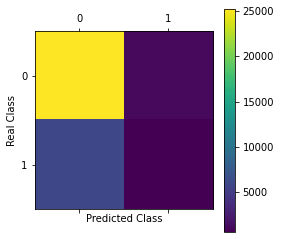

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
## Separa as colunas que vão ser utilizadas na classificação ###
### Naive Bayes ###
df_naive= sus[['Genero_Masculino', 'Idade', 'Hipertensao', 'Diabetes', 
              'Alcoolismo', 'Deficiencia', 'SMS_Alerta', 'TempoEspera', 'BirroInt']].iloc[:len(sus)]
              
#df_naive = sus[['Genero_Masculino', 'Idade', 'SMS_Alerta', 'TempoEspera']].iloc[:len(sus)]

# Separa  a base de treinamento e test - 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(df_naive, sus['Nao_comparecimento'], test_size=0.3, random_state=90) 

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

#Exibe o resultado
obtemMetricasResumido(y_test, y_pred, 'Naive Bayes')
#obtemMetricasCompleto(y_test, y_pred, 'Naive Bayes')

In [19]:
# print the scores on training and test set - Check for overfitting and underfitting
#A pontuação de precisão do conjunto de treinamento é 0.7769, enquanto a precisão do conjunto de teste é 0.7813. 
#Esses dois valores são bastante comparáveis. Portanto, não há sinais de sobreajuste.

print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

Training set score: 0.7744
Test set score: 0.7813


In [82]:
# Print the Confusion Matrix and slice it into four pieces
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[25072  1303]
 [ 6098   671]]

True Positives(TP) =  25072

True Negatives(TN) =  671

False Positives(FP) =  1303

False Negatives(FN) =  6098


### Com Cross Validation


Numero de Compareceu na base: 88168
Numero de Não Compareceu na base: 22312

Acurácia de previsão - Naive Bayes - Cross Validation: 0.7740767559739319
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.81      0.95      0.87     17634
Não Compareceu       0.31      0.10      0.15      4462

      accuracy                           0.77     22096
     macro avg       0.56      0.52      0.51     22096
  weighted avg       0.70      0.77      0.72     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16679                    955
Não Compareceu               4037                    425


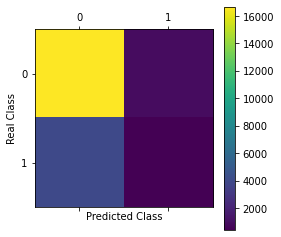


Acurácia de previsão - Naive Bayes - Cross Validation: 0.7754344677769732
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.81      0.95      0.87     17634
Não Compareceu       0.33      0.10      0.16      4462

      accuracy                           0.78     22096
     macro avg       0.57      0.52      0.51     22096
  weighted avg       0.71      0.78      0.73     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16668                    966
Não Compareceu               3996                    466


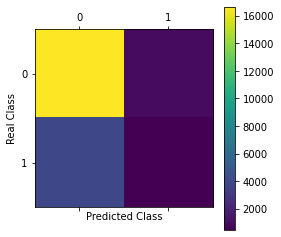


Acurácia de previsão - Naive Bayes - Cross Validation: 0.7744840695148443
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.80      0.95      0.87     17634
Não Compareceu       0.31      0.09      0.14      4462

      accuracy                           0.77     22096
     macro avg       0.56      0.52      0.51     22096
  weighted avg       0.70      0.77      0.72     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16703                    931
Não Compareceu               4052                    410


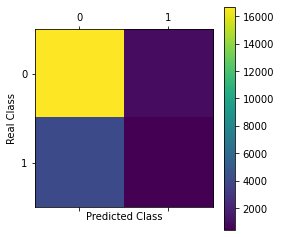


Acurácia de previsão - Naive Bayes - Cross Validation: 0.7730811006517017
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.81      0.94      0.87     17633
Não Compareceu       0.31      0.10      0.15      4463

      accuracy                           0.77     22096
     macro avg       0.56      0.52      0.51     22096
  weighted avg       0.71      0.77      0.72     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16627                   1006
Não Compareceu               4008                    455


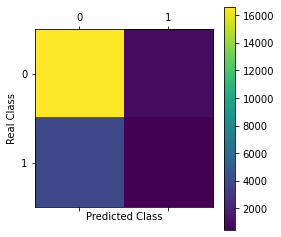


Acurácia de previsão - Naive Bayes - Cross Validation: 0.780095944967415
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.81      0.95      0.87     17633
Não Compareceu       0.35      0.10      0.16      4463

      accuracy                           0.78     22096
     macro avg       0.58      0.53      0.52     22096
  weighted avg       0.71      0.78      0.73     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16783                    850
Não Compareceu               4009                    454


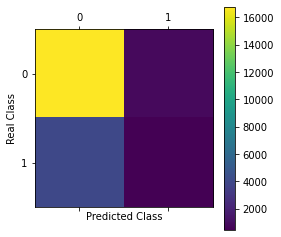

In [25]:
###### Executando  com Cross Validation e avaliando resultado ##############

X = sus[['Genero_Masculino', 'Idade', 'Hipertensao', 'Diabetes', 
               'Alcoolismo', 'Deficiencia', 'SMS_Alerta', 'TempoEspera', 'BirroInt']].iloc[:len(sus)]
y = sus['Nao_comparecimento']

print("\nNumero de Compareceu na base: {}".format(np.count_nonzero(y == 0)))
print("Numero de Não Compareceu na base: {}".format(np.count_nonzero(y == 1)))

kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
for train_index, test_index in kfold.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    obtemMetricasResumido(y_test, y_pred, 'Naive Bayes - Cross Validation')

## Random Forest


Acurácia de previsão - Random Forest Classifier: 0.7737750422399228
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.82      0.91      0.87     26566
Não Compareceu       0.38      0.22      0.28      6578

      accuracy                           0.77     33144
     macro avg       0.60      0.56      0.57     33144
  weighted avg       0.74      0.77      0.75     33144

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  24217                   2349
Não Compareceu               5149                   1429


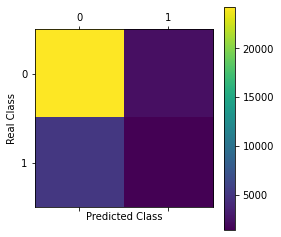

In [30]:
###### RandomForestClassifier ##############
df_naive= sus[['Genero_Masculino', 'Idade', 'Hipertensao', 'Diabetes', 
              'Alcoolismo', 'Deficiencia', 'SMS_Alerta', 'TempoEspera', 'BirroInt']].iloc[:len(sus)]

#df_naive = sus[['Genero_Masculino', 'Idade', 'SMS_Alerta', 'TempoEspera']].iloc[:len(sus)]

# Separa  a base de treinamento e test - 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(df_naive, sus['Nao_comparecimento'], test_size=0.3, random_state=90) 

model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


obtemMetricasResumido(y_test, y_pred, 'Random Forest Classifier')

### Com Cross Validation


Numero de Compareceu na base: 88168
Numero de Não Compareceu na base: 22312

Acurácia de previsão - Random Forest Classifier - Cross Validation: 0.7706372194062274
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.82      0.91      0.86     17634
Não Compareceu       0.38      0.21      0.27      4462

      accuracy                           0.77     22096
     macro avg       0.60      0.56      0.57     22096
  weighted avg       0.73      0.77      0.74     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16089                   1545
Não Compareceu               3523                    939


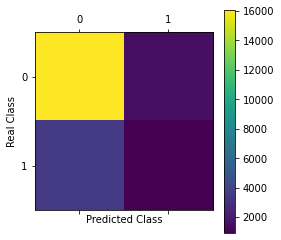


Acurácia de previsão - Random Forest Classifier - Cross Validation: 0.7725832729905865
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.82      0.91      0.87     17634
Não Compareceu       0.39      0.22      0.28      4462

      accuracy                           0.77     22096
     macro avg       0.60      0.57      0.57     22096
  weighted avg       0.73      0.77      0.75     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16102                   1532
Não Compareceu               3493                    969


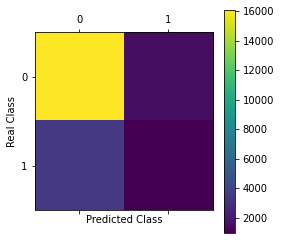


Acurácia de previsão - Random Forest Classifier - Cross Validation: 0.7706372194062274
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.82      0.91      0.86     17634
Não Compareceu       0.38      0.22      0.28      4462

      accuracy                           0.77     22096
     macro avg       0.60      0.56      0.57     22096
  weighted avg       0.73      0.77      0.75     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16048                   1586
Não Compareceu               3482                    980


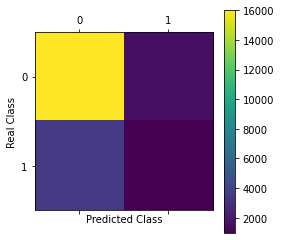


Acurácia de previsão - Random Forest Classifier - Cross Validation: 0.7718139029688631
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.82      0.91      0.86     17633
Não Compareceu       0.39      0.22      0.28      4463

      accuracy                           0.77     22096
     macro avg       0.60      0.57      0.57     22096
  weighted avg       0.73      0.77      0.75     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  16077                   1556
Não Compareceu               3486                    977


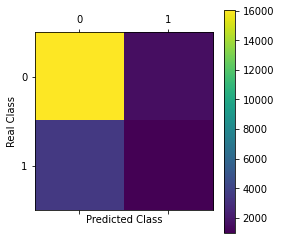


Acurácia de previsão - Random Forest Classifier - Cross Validation: 0.7671071687183201
---------------------------------------------------------------------------- 
                precision    recall  f1-score   support

    Compareceu       0.82      0.90      0.86     17633
Não Compareceu       0.37      0.22      0.28      4463

      accuracy                           0.77     22096
     macro avg       0.60      0.56      0.57     22096
  weighted avg       0.73      0.77      0.74     22096

---------------------------------------------------------------------------- 
                Compareceu (prev)  Não Compareceu (prev)
Compareceu                  15949                   1684
Não Compareceu               3462                   1001


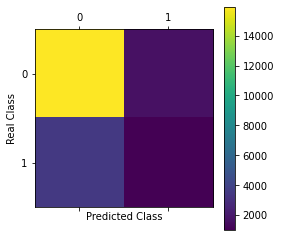

In [31]:
###### Executando Random Forest com Cross Validation ##############

X = sus[['Genero_Masculino', 'Idade', 'Hipertensao', 'Diabetes', 
               'Alcoolismo', 'Deficiencia', 'SMS_Alerta', 'TempoEspera', 'BirroInt']].iloc[:len(sus)]
y = sus['Nao_comparecimento']

print("\nNumero de Compareceu na base: {}".format(np.count_nonzero(y == 0)))
print("Numero de Não Compareceu na base: {}".format(np.count_nonzero(y == 1)))

kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
for train_index, test_index in kfold.split(X, y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      
    model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    obtemMetricasResumido(y_test, y_pred, 'Random Forest Classifier - Cross Validation')


## Nova seção

### Com Cross Validation